In [1]:
# Imports and setup
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime

# NLTK VADER for sentiment
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Ensure vader lexicon available
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except Exception:
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Helper: find a CSV in data/ that looks like news (use raw_analyst_ratings.csv if present)
news_candidates = [os.path.join('data','raw_analyst_ratings.csv'), os.path.join('..','data','raw_analyst_ratings.csv')]
news_path = None
for p in news_candidates:
    if os.path.exists(p):
        news_path = p
        break
if news_path is None:
    # fallback: pick any CSV in data/
    for folder in ['data', os.path.join('..','data')]:
        if os.path.isdir(folder):
            for fname in os.listdir(folder):
                if fname.endswith('.csv'):
                    news_path = os.path.join(folder, fname)
                    break
        if news_path:
            break
if news_path is None:
    raise FileNotFoundError('No news CSV found in data/')

print('Using news file:', news_path)

Using news file: ..\data\raw_analyst_ratings.csv


In [2]:
# Load news CSV and pick columns for text and date
news_df = pd.read_csv(news_path)
# Try to find a text column
text_cols = [c for c in news_df.columns if c.lower() in ('headline','title','text','summary','article','news')]
if not text_cols:
    # fallback: pick the longest text-like column
    candidates = [c for c in news_df.columns if news_df[c].dtype == 'object']
    if candidates:
        # choose the column with the highest average length
        text_cols = [max(candidates, key=lambda c: news_df[c].astype(str).map(len).mean())]
    else:
        raise KeyError('No suitable text column found in news CSV')
text_col = text_cols[0]
# Find a date column
date_cols = [c for c in news_df.columns if c.lower() in ('date','publish_date','datetime','created_at','timestamp')]
date_col = date_cols[0] if date_cols else None
if date_col is None:
    # fallback: try to parse an 'id' or index-like column if it contains datelike strings
    # else create a synthetic date using row order (not ideal).
    raise KeyError('No date-like column found in news CSV; please provide a date column')

print('Text column:', text_col, 'Date column:', date_col)

# Normalize dates
news_df[date_col] = pd.to_datetime(news_df[date_col], errors='coerce')
# Drop rows without valid dates or text
news_df = news_df.dropna(subset=[date_col, text_col])

# Ensure datetime index for grouping by day
news_df['publish_date'] = news_df[date_col].dt.date

# Compute sentiment (compound) for each article
news_df['sentiment'] = news_df[text_col].astype(str).map(lambda s: sia.polarity_scores(s)['compound'])

# Aggregate daily sentiment (mean, count)
daily_sentiment = news_df.groupby('publish_date')['sentiment'].agg(['mean','count']).rename(columns={'mean':'sentiment_mean','count':'article_count'})
daily_sentiment = daily_sentiment.sort_index()
daily_sentiment.head()

Text column: headline Date column: date


,sentiment_mean,article_count
publish_date,,
2011-04-27,0.00000,1
2011-04-28,0.12500,2
2011-04-29,0.36755,2
2011-04-30,0.20230,1
2011-05-01,0.00000,1


In [3]:
# Load stock data (prefer AAPL) and compute daily returns
stock_candidates = [os.path.join('stock_data','AAPL.csv'), os.path.join('..','stock_data','AAPL.csv')]
stock_path = None
for p in stock_candidates:
    if os.path.exists(p):
        stock_path = p
        break
if stock_path is None:
    # pick any CSV in stock_data
    for folder in ['stock_data', os.path.join('..','stock_data')]:
        if os.path.isdir(folder):
            for fname in os.listdir(folder):
                if fname.endswith('.csv'):
                    stock_path = os.path.join(folder, fname)
                    break
        if stock_path:
            break
if stock_path is None:
    raise FileNotFoundError('No stock CSV found in stock_data/')
print('Using stock file:', stock_path)
sd = pd.read_csv(stock_path)
date_col_stock = 'Date' if 'Date' in sd.columns else ('date' if 'date' in sd.columns else None)
if date_col_stock is None:
    raise KeyError('No Date column found in stock CSV')
sd[date_col_stock] = pd.to_datetime(sd[date_col_stock], errors='coerce')
if date_col_stock != 'Date':
    sd = sd.rename(columns={date_col_stock:'Date'})
sd = sd.set_index('Date').sort_index()
# normalize Close column
if 'Close' not in sd.columns:
    for alt in ['close','Adj Close','Adj_Close','AdjClose']:
        if alt in sd.columns:
            sd = sd.rename(columns={alt:'Close'})
            break
sd['Daily_Return'] = sd['Close'].pct_change()
# Create daily returns dataframe with date as date (not datetime)
stock_daily = sd['Daily_Return'].resample('D').mean().to_frame().rename(columns={'Daily_Return':'stock_return'})
stock_daily['date'] = stock_daily.index.date
stock_daily = stock_daily.set_index('date')
stock_daily.head()

Using stock file: ..\stock_data\AAPL.csv


,stock_return
date,
2009-01-02,NaN
2009-01-03,NaN
2009-01-04,NaN
2009-01-05,0.042204
2009-01-06,-0.016494


In [4]:
# Merge daily sentiment with stock returns on date
merged = daily_sentiment.join(stock_daily, how='inner')
merged = merged.dropna(subset=['sentiment_mean','stock_return'])
print('Merged rows:', len(merged))
merged[['sentiment_mean','stock_return']].head()

Merged rows: 2226


,sentiment_mean,stock_return
2011-04-27,0.000000,-0.000770
2011-04-28,0.125000,-0.009710
2011-04-29,0.367550,0.009748
2011-05-02,0.136444,-0.010997
2011-05-03,0.000000,0.005545


Pearson correlation (sentiment_mean vs stock_return): 0.0453
Spearman correlation (sentiment_mean vs stock_return): 0.0290
Lagged Pearson (sentiment -> next day return): -0.0072


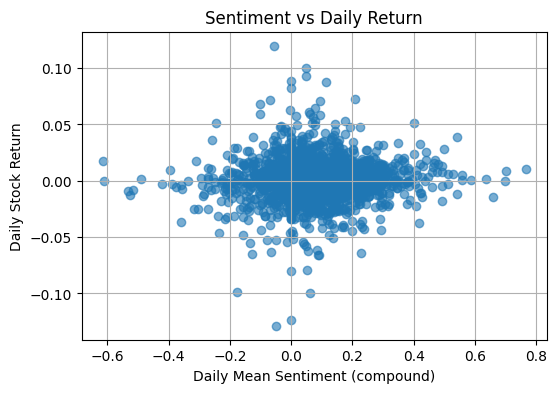

In [5]:
# Compute correlations
pearson = merged['sentiment_mean'].corr(merged['stock_return'], method='pearson')
spearman = merged['sentiment_mean'].corr(merged['stock_return'], method='spearman')
print(f'Pearson correlation (sentiment_mean vs stock_return): {pearson:.4f}')
print(f'Spearman correlation (sentiment_mean vs stock_return): {spearman:.4f}')

# Also compute a 1-day lag (news today -> next trading day return)
merged['stock_return_next'] = merged['stock_return'].shift(-1)
lag_pearson = merged['sentiment_mean'].corr(merged['stock_return_next'])
print(f'Lagged Pearson (sentiment -> next day return): {lag_pearson:.4f}')

# Quick scatter plot
plt.figure(figsize=(6,4))
plt.scatter(merged['sentiment_mean'], merged['stock_return'], alpha=0.6)
plt.xlabel('Daily Mean Sentiment (compound)')
plt.ylabel('Daily Stock Return')
plt.title('Sentiment vs Daily Return')
plt.grid(True)
plt.show()